<a href="https://colab.research.google.com/github/mangeshb1/Gen_AI_And_NLP_Experiments/blob/main/Gen_AI_And_Chatbots/llama_2_and_langchain_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sat Feb 10 19:45:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch==2.0.1 --progress-bar off
!pip install -qqq transformers==4.31.0 --progress-bar off
!pip install -qqq langchain==0.0.266 --progress-bar off
!pip install -qqq chromadb==0.4.5 --progress-bar off
!pip install -qqq pypdf==3.15.0 --progress-bar off
!pip install -qqq xformers==0.0.20 --progress-bar off
!pip install -qqq sentence_transformers==2.2.2 --progress-bar off
!pip install -qqq InstructorEmbedding==1.0.1 --progress-bar off
!pip install -qqq pdf2image==1.16.3 --progress-bar off

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu121 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
torchvision 0.16.0+cu121 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.

In [ ]:
!wget -q https://github.com/PanQiWei/AutoGPTQ/releases/download/v0.4.1/auto_gptq-0.4.1+cu118-cp310-cp310-linux_x86_64.whl

In [ ]:
!pip install -qqq auto_gptq-0.4.1+cu118-cp310-cp310-linux_x86_64.whl --progress-bar off

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.


In [ ]:
#Precompiled command-line utilities (based on Poppler) for manipulating PDF files and converting them to other formats.
!sudo apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 32 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.3 [186 kB]
Fetched 186 kB in 1s (366 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 121749 

In [ ]:
import torch
from auto_gptq import AutoGPTQForCausalLM
from langchain import HuggingFacePipeline, PromptTemplate
from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.embeddings import HuggingFaceInstructEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from pdf2image import convert_from_path
from transformers import AutoTokenizer, TextStreamer, pipeline

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

## Data

In [ ]:
!mkdir pdfs

In [ ]:
!gdown 1v-Rn1FVU1pLTAQEgm0N9oB6cExMoebZr -O pdfs/tesla-earnings-report.pdf
!gdown 1Xc890jrQvCExAkryVWAttsv1DBLdVefN -O pdfs/nvidia-earnings-report.pdf
!gdown 1Epz-SQ3idPpoz75GlTzzomag8gplzLv8 -O pdfs/meta-earnings-report.pdf

Downloading...
From: https://drive.google.com/uc?id=1v-Rn1FVU1pLTAQEgm0N9oB6cExMoebZr
To: /content/pdfs/tesla-earnings-report.pdf
100% 345k/345k [00:00<00:00, 139MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Xc890jrQvCExAkryVWAttsv1DBLdVefN
To: /content/pdfs/nvidia-earnings-report.pdf
100% 414k/414k [00:00<00:00, 110MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Epz-SQ3idPpoz75GlTzzomag8gplzLv8
To: /content/pdfs/meta-earnings-report.pdf
100% 183k/183k [00:00<00:00, 122MB/s]


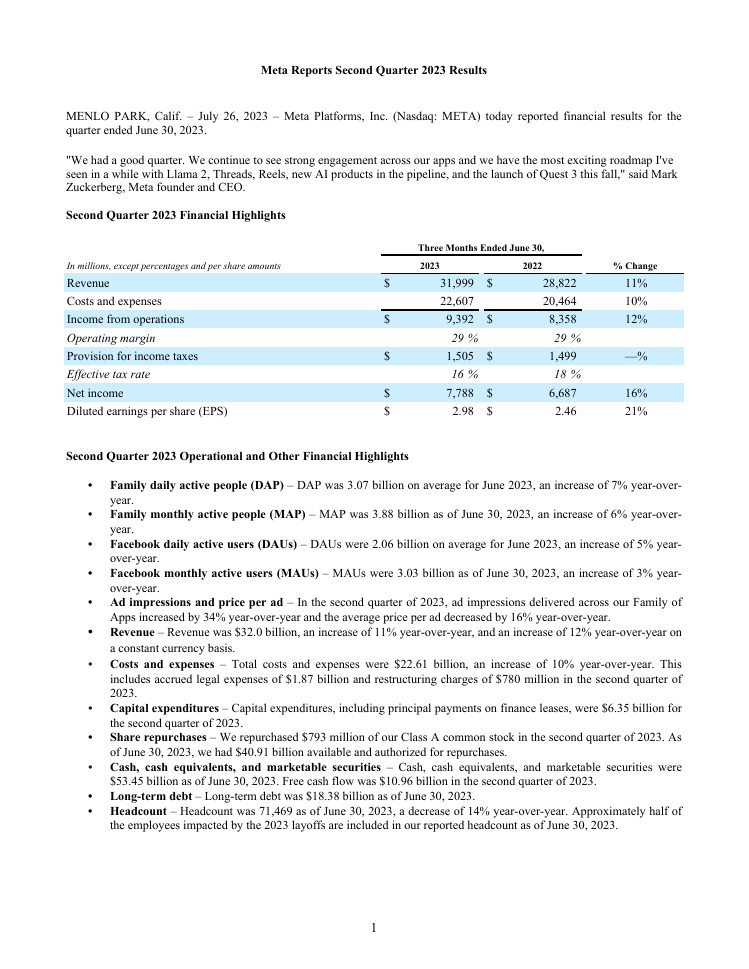

In [ ]:
meta_images = convert_from_path("pdfs/meta-earnings-report.pdf", dpi=88)
meta_images[0]

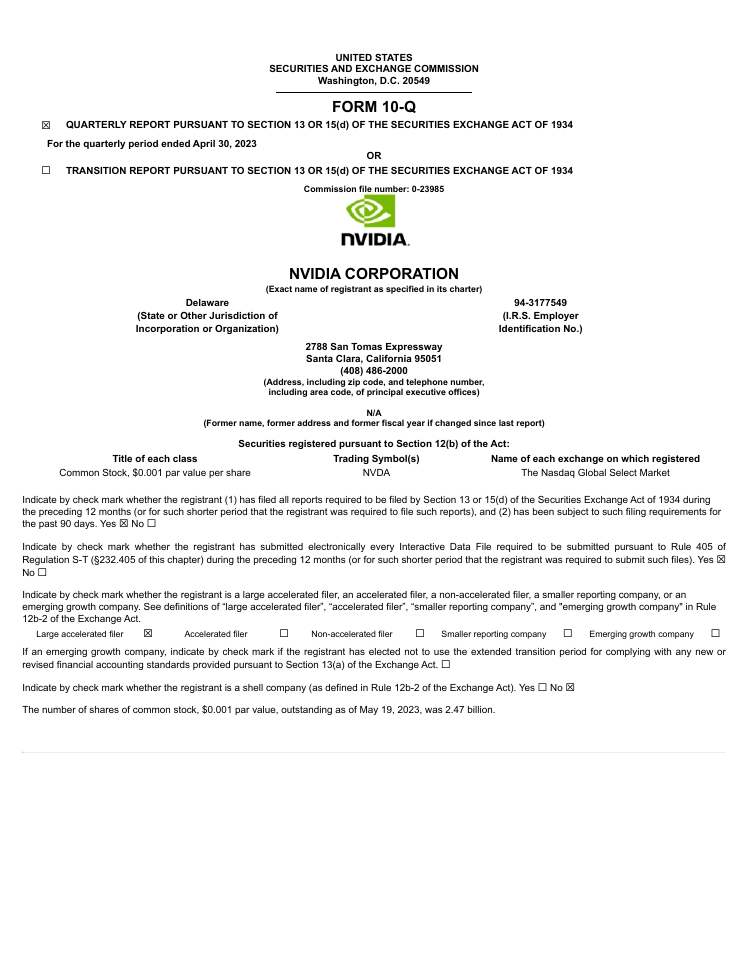

In [ ]:
nvidia_images = convert_from_path("pdfs/nvidia-earnings-report.pdf", dpi=88)
nvidia_images[0]

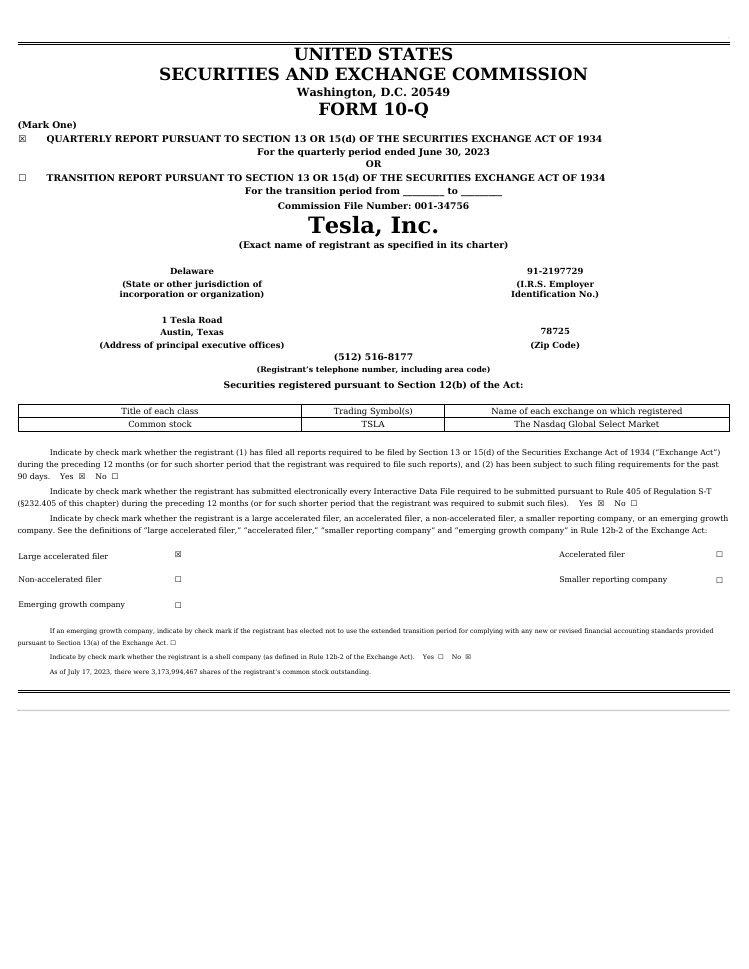

In [ ]:
tesla_images = convert_from_path("pdfs/tesla-earnings-report.pdf", dpi=88)
tesla_images[0]

In [ ]:
!rm -rf "db"

In [ ]:
loader = PyPDFDirectoryLoader("pdfs")
docs = loader.load()
len(docs)

100

In [ ]:
embeddings = HuggingFaceInstructEmbeddings(
    model_name="hkunlp/instructor-large", model_kwargs={"device": DEVICE}
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


HfHubHTTPError: 503 Server Error: Service Temporarily Unavailable for url: https://huggingface.co/api/models/hkunlp/instructor-large

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)
texts = text_splitter.split_documents(docs)
len(texts)

In [ ]:
%%time
db = Chroma.from_documents(texts, embeddings, persist_directory="db")

## Llama 2 13B

In [ ]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GPTQ"
model_basename = "model"

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)

model = AutoGPTQForCausalLM.from_quantized(
    model_name_or_path,
    revision="gptq-4bit-128g-actorder_True",
    model_basename=model_basename,
    use_safetensors=True,
    trust_remote_code=True,
    inject_fused_attention=False,
    device=DEVICE,
    quantize_config=None,
)

In [ ]:
!nvidia-smi

In [ ]:
DEFAULT_SYSTEM_PROMPT = """
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
""".strip()


def generate_prompt(prompt: str, system_prompt: str = DEFAULT_SYSTEM_PROMPT) -> str:
    return f"""
[INST] <<SYS>>
{system_prompt}
<</SYS>>

{prompt} [/INST]
""".strip()

In [ ]:
generate_prompt("Hello, How are you doing?")

"[INST] <<SYS>>\nYou are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.\n\nIf a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.\n<</SYS>>\n\nHello, How are you doing? [/INST]"

In [ ]:
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

In [ ]:
text_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=1024,
    temperature=0,
    top_p=0.95,
    repetition_penalty=1.15,
    streamer=streamer,
)

In [ ]:
llm = HuggingFacePipeline(pipeline=text_pipeline, model_kwargs={"temperature": 0})

In [ ]:
SYSTEM_PROMPT = "Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer."

template = generate_prompt(
    """
{context}

Question: {question}
""",
    system_prompt=SYSTEM_PROMPT,
)

In [ ]:
prompt = PromptTemplate(template=template, input_variables=["context", "question"])

In [ ]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(search_kwargs={"k": 2}),
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt},
)

## Chat with Multiple PDFs

In [ ]:
result = qa_chain("What is the per share revenue for Meta during 2023?")

In [ ]:
len(result["source_documents"])

In [ ]:
print(result["source_documents"][0].page_content)

In [ ]:
result = qa_chain("What is the per share revenue for Tesla during 2023?")

In [ ]:
result = qa_chain("What is the per share revenue for Nvidia during 2023?")

In [ ]:
print(result["source_documents"][1].page_content)

In [ ]:
result = qa_chain("What is the estimated YOY revenue for Meta during 2023?")

In [ ]:
result = qa_chain("What is the estimated YOY revenue for Tesla during 2023?")

In [ ]:
result = qa_chain("What is the estimated YOY revenue for Nvidia during 2023?")

In [ ]:
result = qa_chain(
    "Which company is more profitable during 2023 Meta, Nvidia or Tesla and why?"
)

In [ ]:
result = qa_chain(
    "Choose one company to invest (Tesla, Nvidia or Meta) to maximize your profits for the long term (10+ years)?"
)

## References

- [Tesla Quarterly Report (Jul 21, 2023)](https://ir.tesla.com/_flysystem/s3/sec/000095017023033872/tsla-20230630-gen.pdf)
- [Meta Q2 2023 Earnings (Jul 26, 2023)](https://s21.q4cdn.com/399680738/files/doc_financials/2023/q2/Meta-06-30-2023-Exhibit-99-1-FINAL.pdf)
- [Nvidia Fiscal Q1 2024](https://s201.q4cdn.com/141608511/files/doc_financials/2024/q1/ecefb2b2-efcb-45f3-b72b-212d90fcd873.pdf)